In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "roberta-base-openai-detector"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Loaded model:", model_name, "| Device:", device)

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded model: roberta-base-openai-detector | Device: cpu


In [2]:
def analyse_document(text, max_len=200):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    results = []

    for s in sentences:
        if len(s.strip()) < 2:
            continue
    
        inputs = tokenizer(s, return_tensors="pt", truncation=True, max_length=max_len).to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits[0].cpu()
        ai_prob = torch.softmax(logits, dim=-1)[1].item()  # index 1 = AI class

        results.append({
            "sentence": s,
            "ai_prob": ai_prob
        })
    
    return {
        "sentences": results,
        "overall_ai_score": np.mean([r["ai_prob"] for r in results]) if results else 0
    }

In [3]:
def scatter_sentence_ai_probability(analysis):
    sentences = analysis["sentences"]
    x = np.arange(len(sentences))
    y = [s["ai_prob"] for s in sentences]

    plt.figure(figsize=(12,6))
    plt.scatter(x, y)
    plt.title("Sentence Index vs AI Probability")
    plt.xlabel("Sentence Index")
    plt.ylabel("AI Probability")
    plt.grid(True, alpha=0.3)
    plt.show()

In [4]:
def ai_heatmap(analysis):
    probs = np.array([s["ai_prob"] for s in analysis["sentences"]])

    plt.figure(figsize=(12,2))
    plt.imshow([probs], cmap='hot', aspect='auto')
    plt.colorbar(label="AI Probability")
    plt.title("AI Probability Heatmap Across Document")
    plt.yticks([])
    plt.xlabel("Sentence Index")
    plt.show()


In [5]:
def bar_top_ai_sentences(analysis, top_n=10):
    top = sorted(
        analysis["sentences"], 
        key=lambda x: x["ai_prob"], 
        reverse=True
    )[:top_n]

    sentences = [s["sentence"][:50] + "..." for s in top]
    scores = [s["ai_prob"] for s in top]

    plt.figure(figsize=(12,6))
    plt.barh(sentences, scores)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Most AI-Like Sentences")
    plt.xlabel("AI Probability")
    plt.show()

In [6]:
def pie_ai_vs_human(analysis, threshold=0.5):
    ai_count = len([s for s in analysis["sentences"] if s["ai_prob"] >= threshold])
    human_count = len(analysis["sentences"]) - ai_count
    
    plt.figure(figsize=(6,6))
    plt.pie(
        [ai_count, human_count],
        labels=["AI-written", "Human-written"],
        autopct='%1.1f%%'
    )
    plt.title("AI vs Human Composition")
    plt.show()

In [7]:
def line_ai_trend(analysis):
    y = [s["ai_prob"] for s in analysis["sentences"]]
    x = np.arange(len(y))
    
    plt.figure(figsize=(12,5))
    plt.plot(x, y)
    plt.title("Sentence-by-Sentence AI Probability Trend")
    plt.xlabel("Sentence #")
    plt.ylabel("AI Probability")
    plt.grid(True)
    plt.show()

Overall AI Score: 0.522


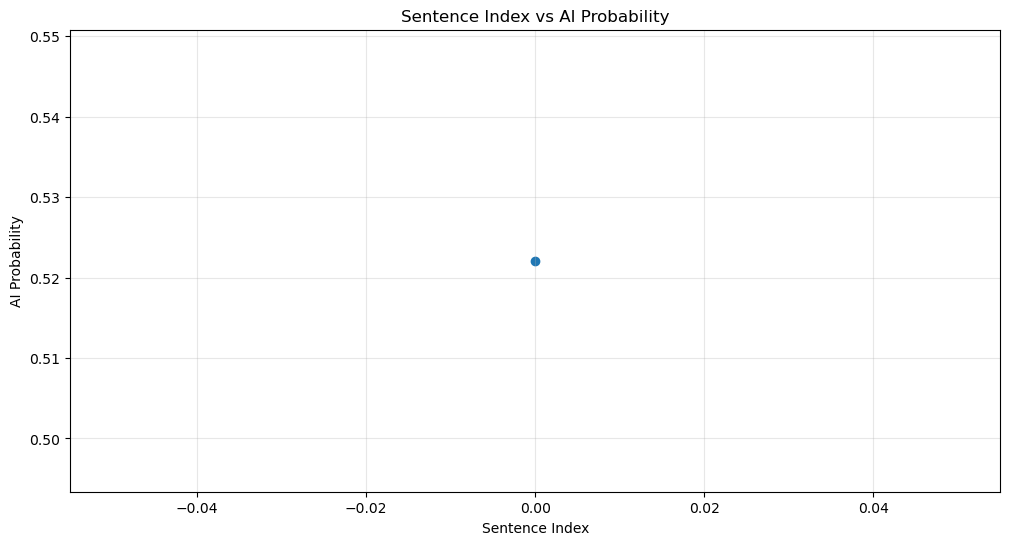

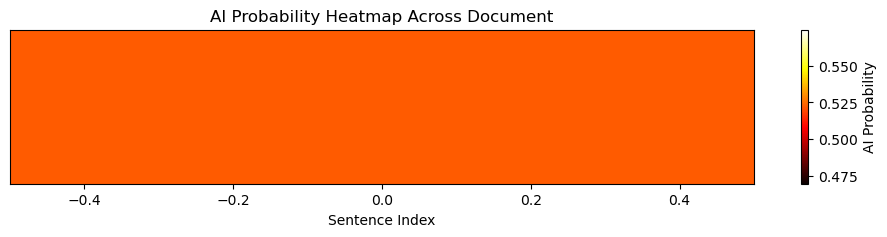

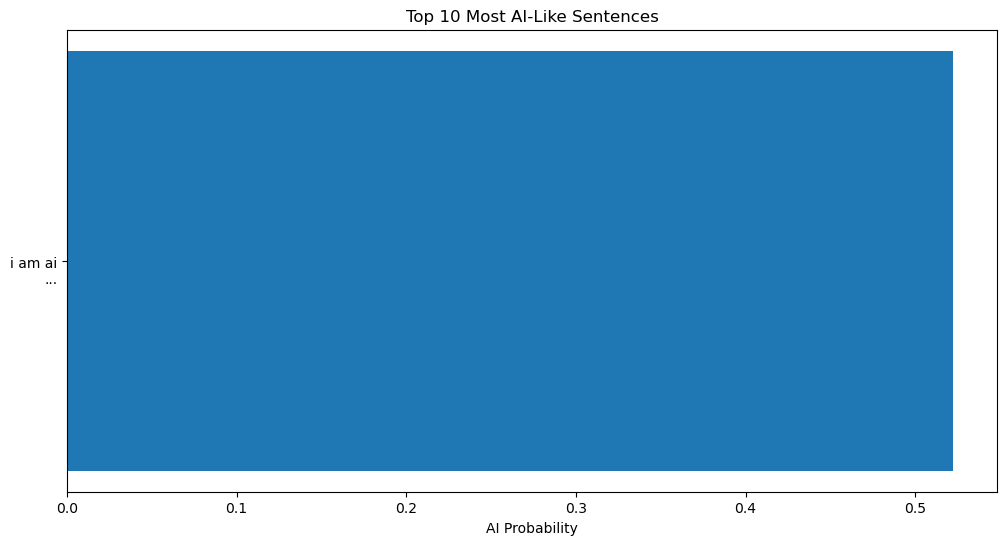

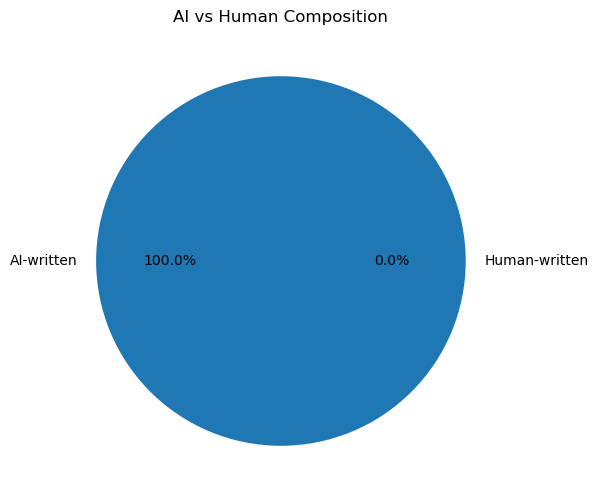

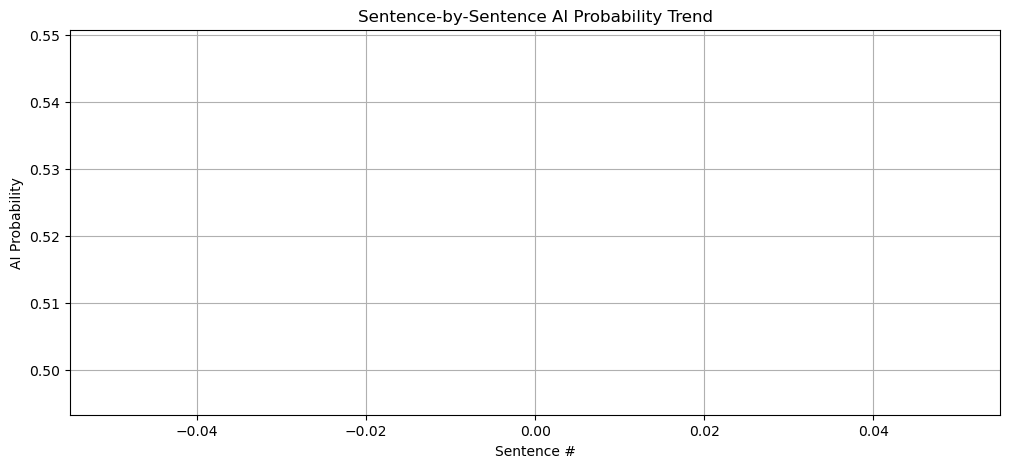

In [8]:
sample_text = """
i am ai
"""

analysis = analyse_document(sample_text)

print("Overall AI Score:", round(analysis["overall_ai_score"], 3))

# VISUALS
scatter_sentence_ai_probability(analysis)
ai_heatmap(analysis)
bar_top_ai_sentences(analysis)
pie_ai_vs_human(analysis)
line_ai_trend(analysis)

In [9]:
import joblib
joblib.dump(model, "my_trained_model.joblib")

['my_trained_model.joblib']